### 決定木の複雑さの制御

一般に、上で述べたような方法で、葉が純粋になるまで分割を続けると、モデルは複雑になりすぎ、訓練データに対して大幅に過剰適合してしまう。葉が純粋になっているということは、訓練セットに対しては100%の精度になっているということである。訓練セットのデータポイントは、俗数はの中で常に正しい多数派クラスになっているからだ。**図2-26**を見れば過剰適合が起きていることがわかる。クラス０の領域の中にクラス１に属する領域がある。これは多くの人が期待する決定境界とは異なるだろう。この決定境界は、そのクラスに属する他の点からかけ離れた場所に１つだけある外れ値を重視しすぎている。

過剰適合を防ぐには２つの戦略がある。構築過程で木の生成を速めに止める**事前枝刈り**（pre-pruning）と、一度木を構築してから、情報の少ないノードを削除する**事後枝刈り**（post-pruning）（ただの**枝刈り**（pruning）とも呼ばれる）である。事前枝刈りの方法としては、木の深さを制限する方法や、葉の最大値を制限する方法、分割する際にその中に含まれている点の最小値を決めておく方法がある。

scikit-learnでは、決定木はDecisionTreeRegressorクラスとDecisionTreeClassifierクラスに実装されている。scikit-learnには事前枝刈りしか実装されていない。事前枝刈りの効果を、cancerデータセットを用いてより詳しく見てみよう。いつものように、データセットを読み込んで訓練セットとデータセットに分割する。次にデフォルトの設定で完全な木を構築する（葉が純粋になるまで木を育てる）。ここでは、内部でタイブレークに使われるrandom_stateを固定している。

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


予想通り、訓練セットの精度は100%である。これは葉が純粋で、訓練データのすべてのラベルを十分なほど木が育っているからだ。テストセットに対する精度は、以前見た線形モデルより少し悪く95%程度になっている。

決定木の深さに制約を与えないと、決定木はいくらでも深く、複雑になる。したがって、枝刈りされていない木は過剰適合になりやすく、新しいデータに対する汎化性能が低い傾向になる。ここで、事前枝刈りを適用して、木が完全に訓練データに適合する前に木の成長を止めてみよう。１つの方法は、木がある深さに達したらそこで止めるという方法だ。ここではmax_depth=4としている。こうすると質問の列は４つまで、ということになる。（**図2-24**、**図2-26**）。木の深さを制限することで過剰適合が抑制される。これによって、訓練制度は下がるが、テストセットに対する精度は向上する。

In [31]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


### 2.3.5.3 決定木の解析

treeモジュールのexport_graphviz関数を使って木を可視化することができる。この関数は、グラフを格納するテキストファイル形式である。.dotファイル形式でファイルを書き出す。ノードにそのノードでの多数派のクラスに応じた色を付けるようにオプションで指定し、木に適切なラベルがつくようにクラスの名前と特徴量の名前を渡している。

In [32]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

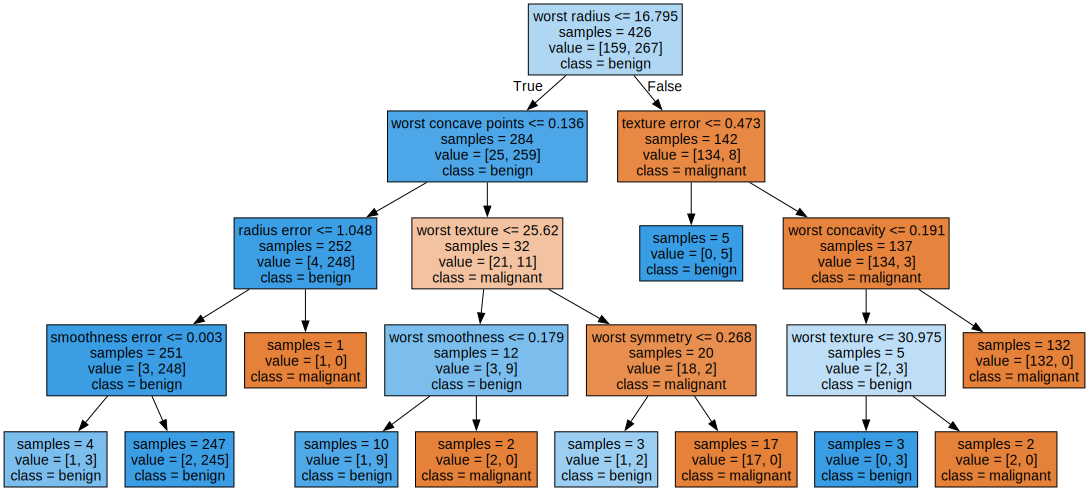

In [33]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

決定木を可視化したものを見ると、アルゴリズムの予測過程をより深く知ることができる。専門家以外にも簡単に説明できる機械学習アルゴリズムの良い例となっている。しかし、ここで見ている深さ４の決定木でも少し圧倒される。もっと深い決定木（深さ10になることも珍しくない）はさらに理解しにくい。決定木を検証するよい方法の１つは、大多数のデータがたどるパスを見つけることである。**図2-27**の**samples**は、そのノードにあるサンプルの個数を示し、**value**はクラスごとのサンプルの個数を示している。ルートから右の枝をたどると、worst radius > 16.795によって作られるノードには、８の良性（benign）と134の悪性（malignant）しかない。こちら側の決定木の残りはより細かい識別を行って、良性の８つのサンプルを分離するために費やされている。最初の分岐で右に行った142のサンプルのうち、そのほとんど（132）が一番右の葉に行きつく。

ルートから左に行った場合、つまりworst radius <= 16.795の場合になるのは、悪性（malignant）25点、良性（benign）259点である。ほとんどすべての良性のサンプル点は左から２番目の葉に行き着き、その他の葉にはごくわずかのサンプル点しかない。

### 2.3.5.4 決定木の特徴量の重要性

決定木全体を見るのは大変なので、決定木から導出できる。決定木の挙動を要約する特性値を見てみよう。要約に最もよく使われるのは、**特徴量の重要度**（feature importance）と呼ばれる、決定木が行う判断にとって、個々の特徴量がどの程度重要かをいｓ雌割合である。それぞれの特徴量に対する０と１の間の数で、０は「全く使われていない」、１は「完全にターゲットを予想できる」を意味する。特徴量の重要度の和は常に１になる。

In [34]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


線形モデルで係数を見た時と同じような方法で、特徴量の重要度を可視化することができる（**図2-28**）。

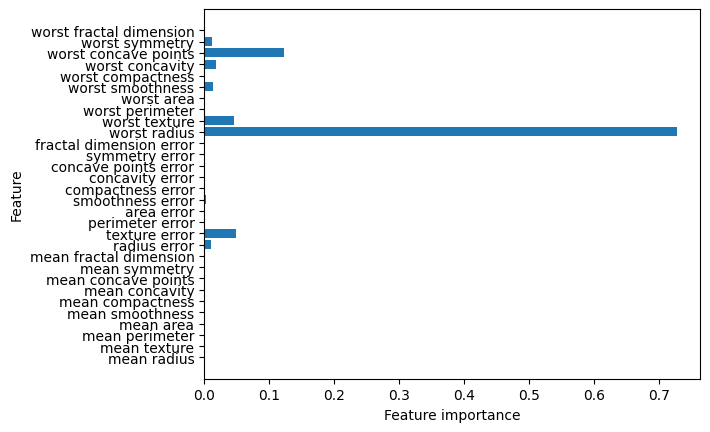

In [35]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_cancer(tree)

**図 2-28 cancerデータセットから学習した決定木から計算した特徴量の重要度**

最初の分岐に用いた特徴量（「worst radius」）が群を抜いて重要な特徴量だということがわかる。これは、決定木を解析した際の、最初のレベルで２つのクラスがかなりきれいに分離できている、という観察悔過kと一致する。

しかし、ある特徴量の重要度（feature_importance_）の値が低いからと言って、その特徴量の持つ情報が少ないとは限らない。単にその決定木で採用されなかった、というだけだ。別の特徴量に同じ情報がエンコードされていることはよくあるので、たまたま採用されないことがあるのだ。

線形モデルの係数と異なり、特徴量の重要度は常に正であり、特徴量がどのクラスを示しているかをエンコードしているわけではない。特徴量の重要度は、サンプルが良性か悪性かを判断する上で、「worst radius」が重要だということを教えてくれるが、この値が大きいと良性になるのか悪性になるのかを教えてくれるわけではない。実際、次の例で示すように、特徴量とクラスの関係はそれほど単純ではない（**図2-29**、**図2-30**）。

Feature importances: [0. 1.]


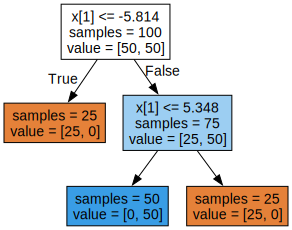

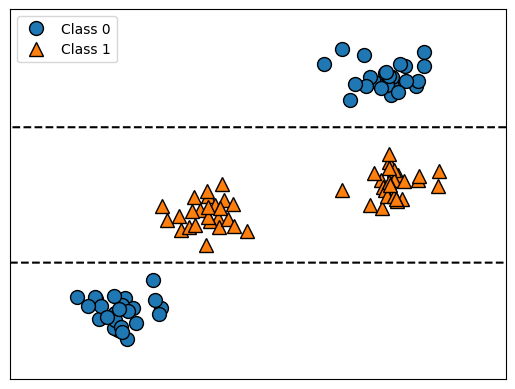

In [36]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

**図2-30 図2-29に対する決定木**  
**図2-29 y軸に対してクラスラベルと単調な関係を持たない２次元データセットと決定木による決定境界**

２つの特長量を持つ２つのクラスからなるデータセットを示している。ここではすべての情報はX[1]にありX[2]は使われていない。しかし、X[1]と出力クラスの関係は単調ではない。つまり、「X[1]の値が大きいとクラス０になり、小さいとクラス１になる（もしくはその逆）」ようなことは言えないわけだ。

ここでは、クラス分類に用いる決定木についてのみ議論してきたが、ここで述べたことは、DecisionTreeRegressorに実装されている決定木による回帰を用いる場合にも同様に当てはまる。回帰決定木の使い方も解析も、クラス分類決定木のそれとほとんど同じだ。ただし、１つだけ決定木によるモデルを回帰に使う際に注意しなければならないことがある。DecisionTreeRegressorは（そしてすべての決定木による回帰モデルは）、**外挿**（extrapolate）ができない。つまり訓練データのレンジの外側に対しては予測できないのだ。

計算機のメモリ（RAM）価格の履歴データセットを使って、詳しく見てみよう。**図2-31**にこのデータセットを示す。$x$軸は年を、$y$軸はメガバイトあたりのRAM価格を示している。

Text(0, 0.5, 'Price in $/Mbyte')

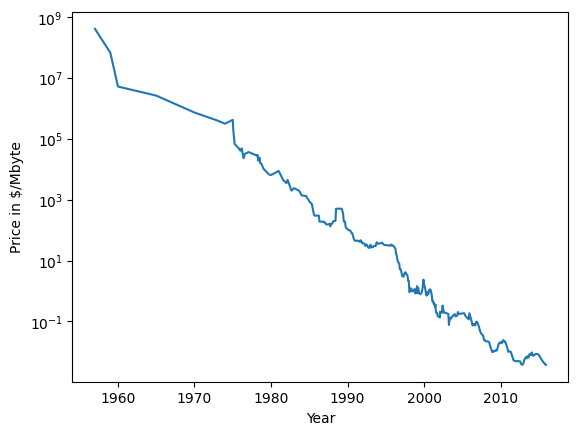

In [37]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

**図2-31 メモリ（RAM）価格の歴史的推移、対数スケールでプロットされている。**

$y$軸が対数スケールになっていることに注意しよう。対数でプロットすると、この関係は多少のデコボコはあるがおおよそ直線になり、予測がしやすくなる。

2000年までのデータを使って、それ以降を予測してみよう。２つの簡単なモデル、DecisionTreeRegressorとLinearRegressionを比較してみよう。価格は対数スケールに直して、関係が比較的線形になるようにしている。これはDecisionTreeRegressorにはあまり関係ないが、LinearRegressionでは非常に重要になる（これについては「**４章 データの表現と特徴量エンジニアリング**」で議論する）。これらのモデルを訓練して予測してみる。結果の値を見るには対数変換をキャンセルするために、指数変換する必要がある。ここでは可視化の都合で、すべてのデータセットに対して予測を行っているが、定量的評価にはテストデータセットだけを考えればよい。

In [38]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 例としてのデータフレームの作成
# 実際のデータを使用する場合は、適切なデータを読み込んでください
# ram_prices = pd.DataFrame({
#     'date': np.arange(1950, 2021),
#     'price': np.exp(np.random.randn(71))  # ランダムな価格データ
# })

# 過去のデータを用いて2000年以降の価格を予想する
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 日付に基づいて価格を予測
X_train = data_train.date.values[:, np.newaxis]
# データとターゲットの関係を単純にするために対数変換
y_train = np.log(data_train.price.values)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 全てのデータに対して予測
X_all = ram_prices.date.values[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# 対数変換をキャンセルするために逆変換
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

**図2-32**は、決定木モデルと線形回帰モデルの予測結果と、実際のデータを比較している。

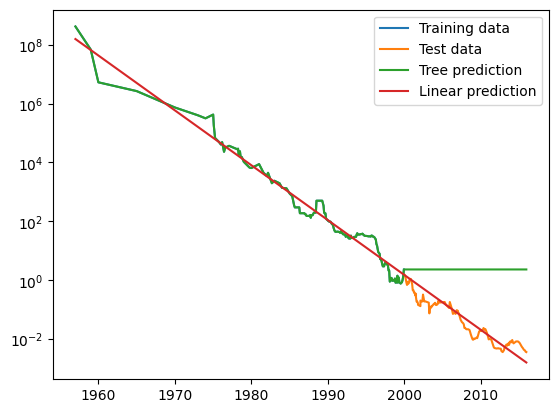

In [39]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

****図2-32** RAM価格データに対する線形回帰モデルによる予測と決定木モデルによる予測の比較**

２つのモデルの違いには驚くべきものがある。線形モデルは、我々が知る通りデータを強く選で近似する。この直線は、訓練データとテストデータの双方において細かい変異を取りこぼしているものの、テストデータ（2000年以降のデータ）に対してかなり良い予測を与えている。一方、決定木のほうは、訓練データに対しては完全なう予測を行う。複雑さを制約していないので、データセットを完全に覚えているからだ。しかし、モデルがデータを持っていない領域になると、決定木は知っている最後の点を返してくるだけになる。決定木は、訓練データにない領域に関しては、「新しい」答えを生成することができないのだ。この欠点は、決定木に基づくすべてのモデルに共通する。

### 23.5.5 長所、短所、パラメータ

これまでに見た通り、決定木におけるモデルの複雑さを制御するパラメータは、決定木が完全に成長する前に構築を停止する事前枝刈りパラメータだ。多くの場合、過剰適合を防ぐには事前枝刈り戦略を指定するmax_depth、max_laef_nodes、min_samples_leafのどれか1つを選ぶだけで十分だ。

決定木にはこれまで見てきたアルゴリズムと比較して、２つの長所がある。結果のモデルが容易に可視化可能で、（少なくとも小さい決定木であれば）専門家でなくても理解可能であること、データのスケジュールに対して完全に不変であることである。個々の特徴量は独立に処理され、データの分割はスケールに依存しないので、決定木においては正規化や標準化は必要ないのだ。決定木は、特徴量ごとにスケールが大きく異なるような場合でも２値特徴量と連続値特徴量が混ざっているような場合でも、問題なく機能する。

決定木の最大の問題点は、事前枝刈りを行ったとしても、過剰適合しやすく、汎化性能が低い傾向があることだ。このため、ほとんどのアプリケーションにおいては、決定木を単体で使うのではなく、次に見るアンサンブル法が用いられる。